<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-up" data-toc-modified-id="Set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set up</a></span></li><li><span><a href="#Read-data" data-toc-modified-id="Read-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read data</a></span><ul class="toc-item"><li><span><a href="#Read-financial-data" data-toc-modified-id="Read-financial-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Read financial data</a></span></li><li><span><a href="#Read-temperature-data" data-toc-modified-id="Read-temperature-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Read temperature data</a></span><ul class="toc-item"><li><span><a href="#Montly-temp-differ-data" data-toc-modified-id="Montly-temp-differ-data-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Montly temp differ data</a></span></li><li><span><a href="#Yearly-temp-differ-data" data-toc-modified-id="Yearly-temp-differ-data-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Yearly temp differ data</a></span></li><li><span><a href="#Bushfire-data" data-toc-modified-id="Bushfire-data-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Bushfire data</a></span></li></ul></li></ul></li><li><span><a href="#US-Average-Temp-difference-Correlation-Analysis" data-toc-modified-id="US-Average-Temp-difference-Correlation-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>US Average Temp difference Correlation Analysis</a></span><ul class="toc-item"><li><span><a href="#Monthly" data-toc-modified-id="Monthly-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Monthly</a></span></li><li><span><a href="#Yearly" data-toc-modified-id="Yearly-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Yearly</a></span></li></ul></li><li><span><a href="#Temp-difference-on-States" data-toc-modified-id="Temp-difference-on-States-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Temp difference on States</a></span><ul class="toc-item"><li><span><a href="#1-year" data-toc-modified-id="1-year-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>1 year</a></span></li><li><span><a href="#2-Year" data-toc-modified-id="2-Year-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>2 Year</a></span></li><li><span><a href="#3-Year" data-toc-modified-id="3-Year-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>3 Year</a></span></li><li><span><a href="#4-Year" data-toc-modified-id="4-Year-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>4 Year</a></span></li><li><span><a href="#5-Year" data-toc-modified-id="5-Year-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>5 Year</a></span></li><li><span><a href="#6-Year" data-toc-modified-id="6-Year-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>6 Year</a></span></li><li><span><a href="#7-Year" data-toc-modified-id="7-Year-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>7 Year</a></span></li><li><span><a href="#8-Year" data-toc-modified-id="8-Year-4.8"><span class="toc-item-num">4.8&nbsp;&nbsp;</span>8 Year</a></span></li><li><span><a href="#9-Year" data-toc-modified-id="9-Year-4.9"><span class="toc-item-num">4.9&nbsp;&nbsp;</span>9 Year</a></span></li><li><span><a href="#10-Year" data-toc-modified-id="10-Year-4.10"><span class="toc-item-num">4.10&nbsp;&nbsp;</span>10 Year</a></span></li></ul></li><li><span><a href="#Bushfires" data-toc-modified-id="Bushfires-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bushfires</a></span></li><li><span><a href="#Appendix" data-toc-modified-id="Appendix-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Appendix</a></span><ul class="toc-item"><li><span><a href="#Person" data-toc-modified-id="Person-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Person</a></span></li><li><span><a href="#Spearman" data-toc-modified-id="Spearman-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Spearman</a></span></li><li><span><a href="#Kendall" data-toc-modified-id="Kendall-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Kendall</a></span></li></ul></li></ul></div>

# Set up

In [1]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau

import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd
import json
import re, datetime
from geopy.geocoders import Nominatim

# Read data

## Read financial data

In [2]:
def toInt(l:list) -> list:
    for i in range(len(l)):
        l[i] = float(l[i])

root_path = os.path.abspath(os.path.dirname(os.getcwd()))
data_path = os.path.join(root_path, 'data')
agr_path = os.path.join(data_path, 'agriculture')

finc_data = []
for file in os.listdir(agr_path):
    if file.endswith('.json'):
        file_path = os.path.join(agr_path, file)
        with open(file_path, 'r') as file:
            finc_data.append(json.load(file))
        
ROA_data = {}
state_data = {}
for i in finc_data:
    for k, v in i.items():
        try:
            state_data[k] =  i[k]['state']
            ROA_data[k] = pd.DataFrame.from_dict(i[k]['ROA']) 
        except:
            pass

In [3]:
finc_data[1]['YTEN'].keys()

dict_keys(['name', 'location', 'website', 'section', 'industry', 'profile', 'stock prices', 'ROA', 'state'])

In [4]:
finc_data[1]

{'YTEN': {'name': 'Yield10 Bioscience, Inc.',
  'location': ['19 Presidential Way', 'Woburn, MA 01801', 'United States'],
  'website': 'http://www.yield10bio.com',
  'section': 'Basic Materials',
  'industry': 'Agricultural Inputs',
  'profile': 'https://finance.yahoo.com/quote/YTEN/profile?p=YTEN',
  'stock prices': {'Date': {'0': '2006-11-10',
    '1': '2006-11-13',
    '2': '2006-11-14',
    '3': '2006-11-15',
    '4': '2006-11-16',
    '5': '2006-11-17',
    '6': '2006-11-20',
    '7': '2006-11-21',
    '8': '2006-11-22',
    '9': '2006-11-24',
    '10': '2006-11-27',
    '11': '2006-11-28',
    '12': '2006-11-29',
    '13': '2006-11-30',
    '14': '2006-12-01',
    '15': '2006-12-04',
    '16': '2006-12-05',
    '17': '2006-12-06',
    '18': '2006-12-07',
    '19': '2006-12-08',
    '20': '2006-12-11',
    '21': '2006-12-12',
    '22': '2006-12-13',
    '23': '2006-12-14',
    '24': '2006-12-15',
    '25': '2006-12-18',
    '26': '2006-12-19',
    '27': '2006-12-20',
    '28': '20

In [5]:
finc_data[1]['YTEN']['state']

'Massachusetts'

In [6]:
# transform dict to pd
pd.DataFrame.from_dict(finc_data[0]['RKDA']['stock prices']) 

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-05-15,154.000000,141.199997,149.800003,146.000000,79130.0,146.000000
1,2015-05-18,160.800003,142.000000,145.000000,149.000000,12200.0,149.000000
2,2015-05-19,156.800003,146.000000,154.000000,156.000000,5005.0,156.000000
3,2015-05-20,158.000000,151.199997,152.800003,155.800003,5810.0,155.800003
4,2015-05-21,158.000000,151.800003,153.800003,157.800003,5175.0,157.800003
...,...,...,...,...,...,...,...
1414,2020-12-24,2.640000,2.530000,2.610000,2.580000,207200.0,2.580000
1415,2020-12-28,2.665000,2.510000,2.650000,2.540000,410800.0,2.540000
1416,2020-12-29,2.570000,2.421000,2.540000,2.470000,377000.0,2.470000
1417,2020-12-30,2.540000,2.475000,2.500000,2.490000,269500.0,2.490000


## Read temperature data

### Montly temp differ data

In [7]:
climate_path = os.path.join(data_path, 'climate')
climate_path = os.path.join(climate_path, 'US_temperature_data')

file_name = 'monthly_temp_difference(1980-2013).csv'
file_path = os.path.join(climate_path, file_name)
temp_diff_montly_data = pd.read_csv(file_path)

rename the time_difference

In [8]:
time_diff = []
for i in temp_diff_montly_data["Time_Difference"]:
    i = i.split('-')
    month = re.compile(r'(?<= )\d+(?=])')
    month = re.search(month, i[-1])[0] # get the month
    i = month + '/31/' + i[0]
    time_diff.append(i)
temp_diff_montly_data["Time_Difference"] = time_diff

### Yearly temp differ data

In [9]:
climate_path = os.path.join(data_path, 'climate')
climate_path = os.path.join(climate_path, 'US_temperature_data')

file_name = 'Yearly_temp_difference.csv'
file_path = os.path.join(climate_path, file_name)
temp_diff_yearly_data = pd.read_csv(file_path)

### Bushfire data

In [10]:
climate_path = os.path.join(data_path, 'climate')

file_name = 'Wildfire_data.csv'
file_path = os.path.join(climate_path, file_name)
bushfire_data = pd.read_csv(file_path)

# US Average Temp difference Correlation Analysis

1. `SEED` = ROA varies a little
2. cluster between ROA and temperature

In [11]:
def corr_ana(l1:list, l2:list, x, y):
    print('123')
    assert len(roa_data) == len(temp_data)
    if len(l1) > 5:
        # Pearson correlation
        pearson = pearsonr(l1, l2)[0]
        p_p_value = pearsonr(l1, l2)[1]
        # Spearman correlation
        spearman = spearmanr(l1, l2)[0]
        s_p_value = spearmanr(l1, l2)[1]
        # Kendall correlation
        tau, k_p_value = kendalltau(l1, l2)
        # print the results
        print("""Correlation analysis between {comp} and montly temp difference:
        Perason coefficient is {pearson:.3f} with {p_p_value:.3f} p-value.
        Spearman coefficient is {spearman:.3f} with {s_p_value:.3f} p-value.
        Kendall coefficient is {kendall:.3f} with {k_p_value:.3f} p-value.
        """.format(comp = comp, pearson = pearson, p_p_value = p_p_value,
                    spearman = spearman, s_p_value = s_p_value, 
                     kendall = tau, k_p_value = k_p_value))
        plt.scatter(l1, l2)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.show()
    else:
        print("\nData Insufficient.\n")

## Monthly

123

Data Insufficient.

123
Correlation analysis between YTEN and montly temp difference:
        Perason coefficient is 0.082 with 0.823 p-value.
        Spearman coefficient is 0.042 with 0.907 p-value.
        Kendall coefficient is 0.022 with 1.000 p-value.
        


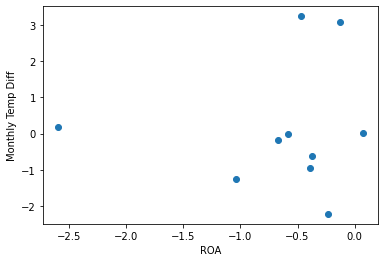

123
Correlation analysis between AVD and montly temp difference:
        Perason coefficient is -0.251 with 0.207 p-value.
        Spearman coefficient is -0.263 with 0.185 p-value.
        Kendall coefficient is -0.181 with 0.200 p-value.
        


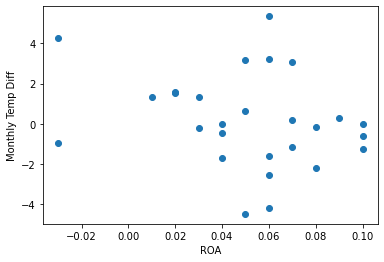

123

Data Insufficient.

123
Correlation analysis between IPI and montly temp difference:
        Perason coefficient is 0.296 with 0.519 p-value.
        Spearman coefficient is 0.071 with 0.879 p-value.
        Kendall coefficient is 0.048 with 1.000 p-value.
        


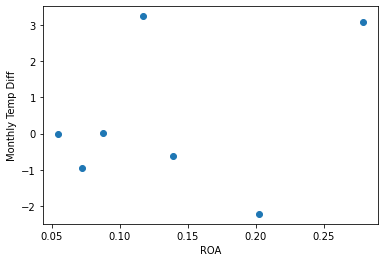

123

Data Insufficient.

123

Data Insufficient.

123
Correlation analysis between FMC and montly temp difference:
        Perason coefficient is -0.227 with 0.255 p-value.
        Spearman coefficient is 0.100 with 0.619 p-value.
        Kendall coefficient is 0.077 with 0.591 p-value.
        


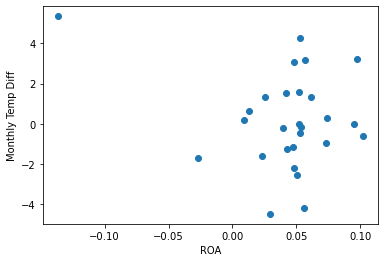

123

Data Insufficient.

123

Data Insufficient.

123

Data Insufficient.

123
Correlation analysis between CF and montly temp difference:
        Perason coefficient is 0.003 with 0.994 p-value.
        Spearman coefficient is 0.018 with 0.958 p-value.
        Kendall coefficient is -0.018 with 1.000 p-value.
        


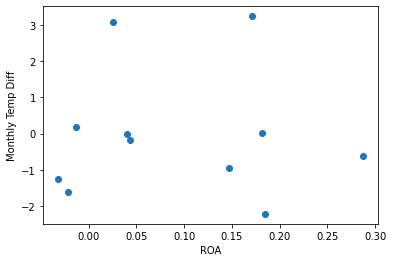

123

Data Insufficient.

123
Correlation analysis between MOS and montly temp difference:
        Perason coefficient is 0.392 with 0.384 p-value.
        Spearman coefficient is 0.536 with 0.215 p-value.
        Kendall coefficient is 0.333 with 0.381 p-value.
        


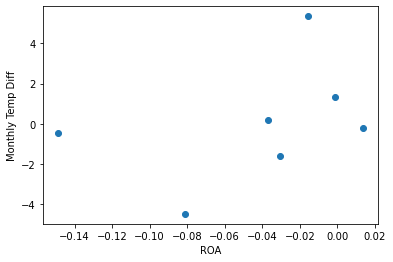

In [12]:
for comp in ROA_data.keys():
    roa_data = []
    temp_data = []
    for i in ROA_data[comp].iloc[:,range(1, ROA_data[comp].shape[1])]:
#         print(i)
        try: 
            t = temp_diff_montly_data.loc[temp_diff_montly_data['Time_Difference'] == i]['Temperature_Difference']
            t = t.values[0]
            if t:
                roa = ROA_data[comp][i].values[0]
                roa = float(roa)
                if roa and not np.isnan(roa): # to aviod nan value
                    roa_data.append(roa)
                    temp_data.append(t)
        except:
            pass
        # try correlation analysis
    corr_ana(roa_data, temp_data, 'ROA', 'Monthly Temp Diff')

## Yearly

123

Data Insufficient.

123
Correlation analysis between YTEN and montly temp difference:
        Perason coefficient is 0.336 with 0.313 p-value.
        Spearman coefficient is 0.191 with 0.574 p-value.
        Kendall coefficient is 0.055 with 0.879 p-value.
        


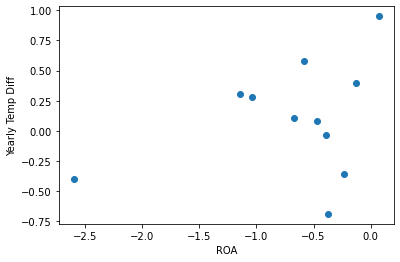

123
Correlation analysis between AVD and montly temp difference:
        Perason coefficient is -0.166 with 0.400 p-value.
        Spearman coefficient is -0.059 with 0.766 p-value.
        Kendall coefficient is -0.022 with 0.874 p-value.
        


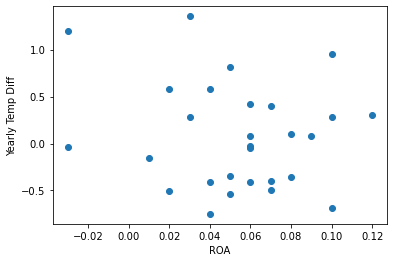

123

Data Insufficient.

123
Correlation analysis between IPI and montly temp difference:
        Perason coefficient is -0.252 with 0.546 p-value.
        Spearman coefficient is -0.333 with 0.420 p-value.
        Kendall coefficient is -0.214 with 0.548 p-value.
        


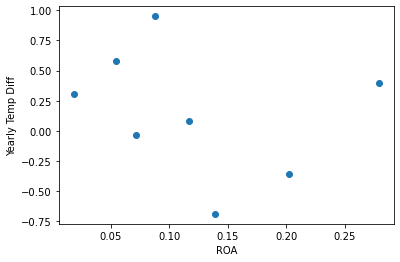

123
Correlation analysis between MGPI and montly temp difference:
        Perason coefficient is -0.008 with 0.968 p-value.
        Spearman coefficient is -0.149 with 0.466 p-value.
        Kendall coefficient is -0.108 with 0.457 p-value.
        


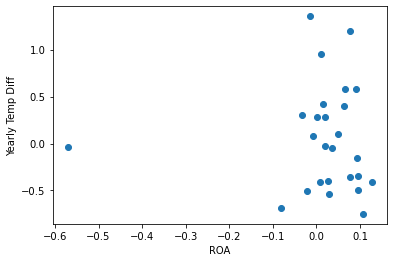

123
Correlation analysis between SMG and montly temp difference:
        Perason coefficient is 0.043 with 0.840 p-value.
        Spearman coefficient is 0.182 with 0.395 p-value.
        Kendall coefficient is 0.159 with 0.290 p-value.
        


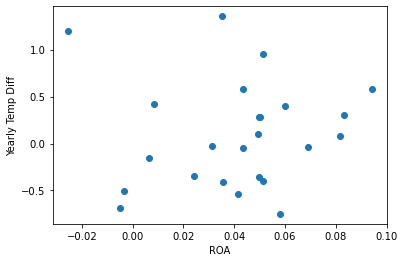

123
Correlation analysis between FMC and montly temp difference:
        Perason coefficient is 0.037 with 0.851 p-value.
        Spearman coefficient is 0.147 with 0.455 p-value.
        Kendall coefficient is 0.132 with 0.336 p-value.
        


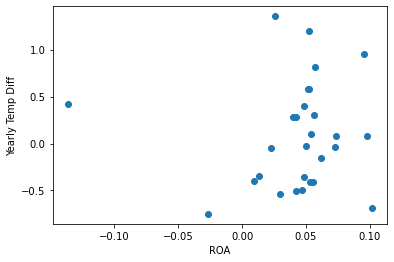

123

Data Insufficient.

123

Data Insufficient.

123
Correlation analysis between UAN and montly temp difference:
        Perason coefficient is -0.673 with 0.143 p-value.
        Spearman coefficient is -0.543 with 0.266 p-value.
        Kendall coefficient is -0.467 with 0.272 p-value.
        


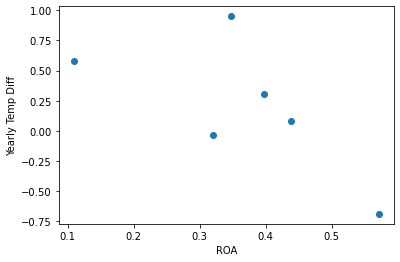

123
Correlation analysis between CF and montly temp difference:
        Perason coefficient is -0.232 with 0.467 p-value.
        Spearman coefficient is -0.182 with 0.572 p-value.
        Kendall coefficient is -0.152 with 0.545 p-value.
        


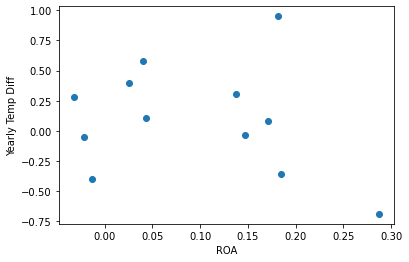

123

Data Insufficient.

123
Correlation analysis between MOS and montly temp difference:
        Perason coefficient is 0.126 with 0.539 p-value.
        Spearman coefficient is 0.166 with 0.418 p-value.
        Kendall coefficient is 0.105 with 0.453 p-value.
        


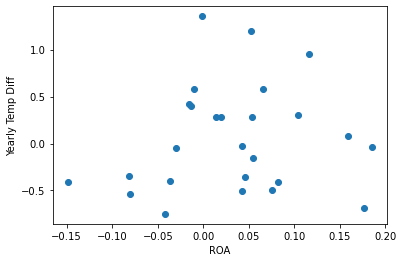

In [13]:
for comp in ROA_data.keys(): 
    roa_data = []
    temp_data = []
    for i in ROA_data[comp].iloc[:,range(1, ROA_data[comp].shape[1])]:
        year = i.split('/')[-1]
        try: 
            t = temp_diff_yearly_data.loc[temp_diff_yearly_data['Year'] == int(year)]['Difference']
            t = t.values[0]
            if t:
                roa = ROA_data[comp][i][0]
                roa = float(roa)
                if roa and not np.isnan(roa):
                    roa_data.append(roa)
                    temp_data.append(t)
        except:
            pass
    corr_ana(roa_data, temp_data, 'ROA', 'Yearly Temp Diff')

# Temp difference on States

In [14]:
# get us companies
us_comps = []

for comp in finc_data:
    name = list(comp.keys())[0]
    if comp[name]['location'][-1] == 'United States':
        us_comps.append(comp)

# read raw temp data
climate_path = os.path.join(climate_path, 'US_temperature_data')
file_name = 'original_temp_data.csv'
file_path = os.path.join(climate_path, file_name)
raw_temp_date = pd.read_csv(file_path)

Want I want = the pairs of (ROA, temp differ)

The logic:

1. get the state of the company
2. get the state temperature 
3. according to the company's ROA date, get the timeline which helps us to find the corresponding temperature data
4. temperature difference = current year avg. temp - the past *n* years avg. temp

In [15]:
def temp_diff_roa_pairs(skip: int, comp):
    """
    :i = the past n year(s)
    :comp = comp
    """
    state = state_data[comp] # get state
    state_temp = raw_temp_date.loc[raw_temp_date['State'] == state] # get state temp date
    state_temp = state_temp.set_index("Date") # set Date as row index
    
    # get roa timeline
    roa_time = []
    for i in ROA_data[comp].iloc[:,range(1, ROA_data[comp].shape[1])]:
        try:
            i = i.split('/')
            roa_time.append(datetime.date(int(i[-1]), int(i[0]), int(i[1])))
        except:
            pass
        
    # get temp timeline
    state_temp_time = []
    for i in state_temp.index.values:
        i = i.split('/')
        state_temp_time.append(datetime.date(int(i[0]), int(i[1]), int(i[2])))
    
    # get the roa interval
    
    # get the temp timeline 
    
    temp_curr_avg = []
    temp_past_avg = []
    roa_index = []
    for roa in range(len(roa_time)-1):
        now = roa_time[roa]
        now_year = roa_time[roa].year
        now_month = roa_time[roa].month
        now_day = roa_time[roa].day
        past = roa_time[roa + 1]
        past_year = roa_time[roa + 1].year
        past_month = roa_time[roa + 1].month
        past_day = roa_time[roa + 1].day
        temp_sum = 0
        temp_count = 0
        # get current year
        for temp in range(len(state_temp_time)):
            if past <= state_temp_time[temp] < now:
                year = str(state_temp_time[temp].year)
                month = str(state_temp_time[temp].month)
                day = str(state_temp_time[temp].day)
                timestamp = year + '/' + month + '/' + day
                temp_sum += state_temp.loc[timestamp].values[0]
                temp_count += 1       
        if temp_count == 0:
            continue
        temp_curr_avg.append(temp_sum/temp_count)
        temp_count = 0
        # get the past year
        for n in range(1, skip+1):
            now_year -= n
            past_year -= n
            now = datetime.date(now_year, now_month, now_day)
            past = datetime.date(past_year, past_month, past_day)
            for temp in range(len(state_temp_time)):
                if past <= state_temp_time[temp] < now:
                    year = str(state_temp_time[temp].year)
                    month = str(state_temp_time[temp].month)
                    day = str(state_temp_time[temp].day)
                    timestamp = year + '/' + month + '/' + day
                    temp_sum += state_temp.loc[timestamp].values[0]
                    temp_count += 1
        temp_past_avg.append(temp_sum/temp_count)
        roa_index.append(roa)
    roa_data = []
    count = 0
    # get roa_data
    for i in ROA_data[comp].iloc[:,range(1, ROA_data[comp].shape[1])]:
        count += 1
        if count in roa_index:
            roa_data.append(float(ROA_data[comp][i].values[0]))
    # get temp difference
    temp_diff = [a + b for a, b in zip(temp_curr_avg, temp_past_avg)]
    return temp_diff, roa_data

## 1 year

123

Data Insufficient.

123
Correlation analysis between YTEN and montly temp difference:
        Perason coefficient is -0.098 with 0.775 p-value.
        Spearman coefficient is -0.018 with 0.958 p-value.
        Kendall coefficient is 0.127 with 0.648 p-value.
        


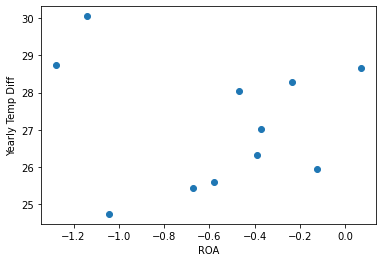

123
Correlation analysis between AVD and montly temp difference:
        Perason coefficient is 0.071 with 0.727 p-value.
        Spearman coefficient is 0.109 with 0.589 p-value.
        Kendall coefficient is 0.080 with 0.571 p-value.
        


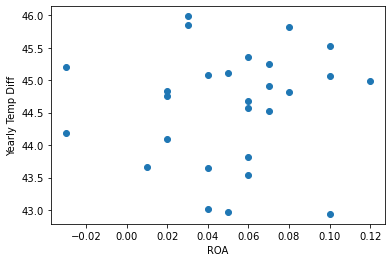

123

Data Insufficient.

123
Correlation analysis between IPI and montly temp difference:
        Perason coefficient is -0.509 with 0.243 p-value.
        Spearman coefficient is -0.286 with 0.535 p-value.
        Kendall coefficient is -0.048 with 1.000 p-value.
        


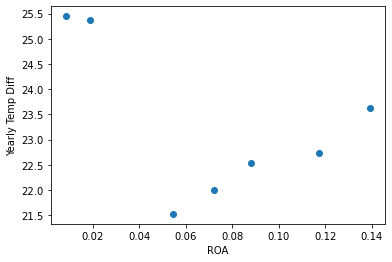

123
Correlation analysis between MGPI and montly temp difference:
        Perason coefficient is 0.039 with 0.854 p-value.
        Spearman coefficient is 0.180 with 0.389 p-value.
        Kendall coefficient is 0.127 with 0.391 p-value.
        


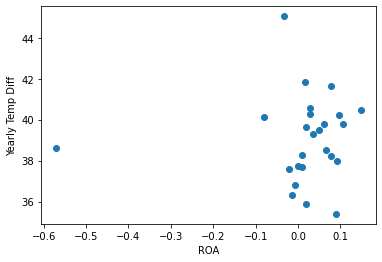

123
Correlation analysis between SMG and montly temp difference:
        Perason coefficient is 0.155 with 0.479 p-value.
        Spearman coefficient is 0.208 with 0.340 p-value.
        Kendall coefficient is 0.138 with 0.373 p-value.
        


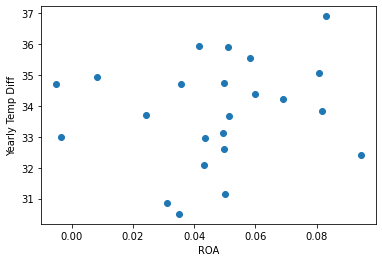

123
Correlation analysis between FMC and montly temp difference:
        Perason coefficient is 0.041 with 0.841 p-value.
        Spearman coefficient is 0.148 with 0.460 p-value.
        Kendall coefficient is 0.100 with 0.482 p-value.
        


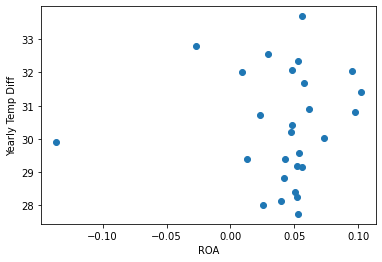

123

Data Insufficient.

123

Data Insufficient.

123

Data Insufficient.

123
Correlation analysis between CF and montly temp difference:
        Perason coefficient is 0.396 with 0.203 p-value.
        Spearman coefficient is 0.329 with 0.297 p-value.
        Kendall coefficient is 0.242 with 0.311 p-value.
        


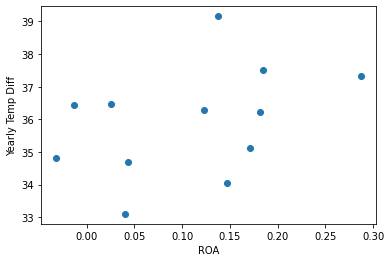

123

Data Insufficient.

123
Correlation analysis between MOS and montly temp difference:
        Perason coefficient is -0.113 with 0.583 p-value.
        Spearman coefficient is -0.106 with 0.608 p-value.
        Kendall coefficient is -0.065 with 0.662 p-value.
        


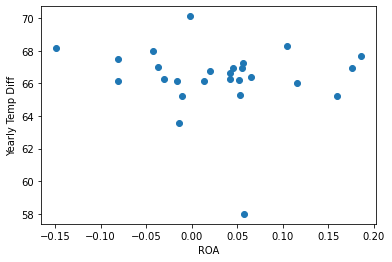

In [16]:
for comp in ROA_data.keys(): 
    temp_data, roa_data = temp_diff_roa_pairs(1, comp)
    corr_ana(roa_data, temp_data, 'ROA', 'Yearly Temp Diff')

## 2 Year

123

Data Insufficient.

123
Correlation analysis between YTEN and montly temp difference:
        Perason coefficient is -0.232 with 0.492 p-value.
        Spearman coefficient is -0.027 with 0.937 p-value.
        Kendall coefficient is 0.055 with 0.879 p-value.
        


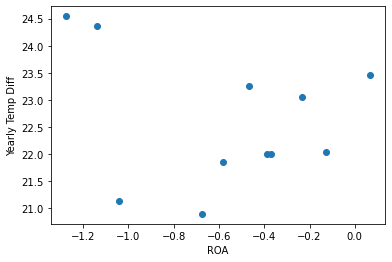

123
Correlation analysis between AVD and montly temp difference:
        Perason coefficient is 0.097 with 0.631 p-value.
        Spearman coefficient is 0.130 with 0.518 p-value.
        Kendall coefficient is 0.110 with 0.437 p-value.
        


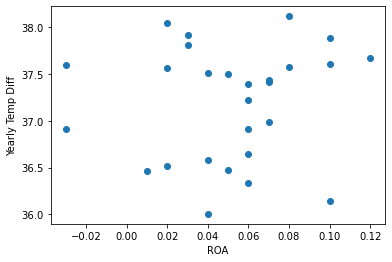

123

Data Insufficient.

123
Correlation analysis between IPI and montly temp difference:
        Perason coefficient is -0.571 with 0.181 p-value.
        Spearman coefficient is -0.321 with 0.482 p-value.
        Kendall coefficient is -0.143 with 0.773 p-value.
        


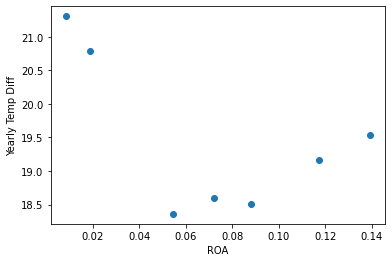

123
Correlation analysis between MGPI and montly temp difference:
        Perason coefficient is 0.051 with 0.809 p-value.
        Spearman coefficient is 0.218 with 0.294 p-value.
        Kendall coefficient is 0.160 with 0.275 p-value.
        


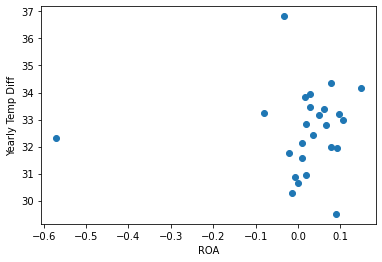

123
Correlation analysis between SMG and montly temp difference:
        Perason coefficient is 0.225 with 0.303 p-value.
        Spearman coefficient is 0.342 with 0.110 p-value.
        Kendall coefficient is 0.209 with 0.172 p-value.
        


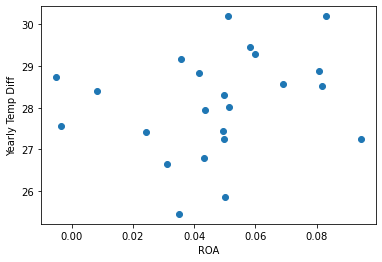

123
Correlation analysis between FMC and montly temp difference:
        Perason coefficient is 0.136 with 0.499 p-value.
        Spearman coefficient is 0.190 with 0.341 p-value.
        Kendall coefficient is 0.123 with 0.385 p-value.
        


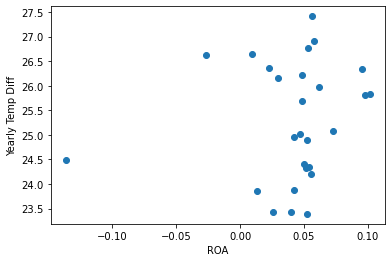

123

Data Insufficient.

123

Data Insufficient.

123

Data Insufficient.

123
Correlation analysis between CF and montly temp difference:
        Perason coefficient is 0.300 with 0.343 p-value.
        Spearman coefficient is 0.378 with 0.226 p-value.
        Kendall coefficient is 0.303 with 0.197 p-value.
        


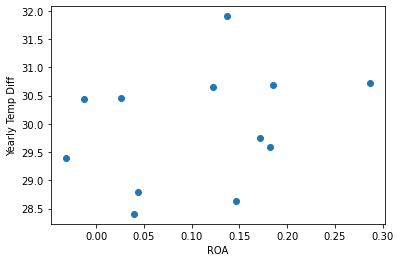

123

Data Insufficient.

123
Correlation analysis between MOS and montly temp difference:
        Perason coefficient is -0.086 with 0.674 p-value.
        Spearman coefficient is -0.072 with 0.726 p-value.
        Kendall coefficient is -0.040 with 0.793 p-value.
        


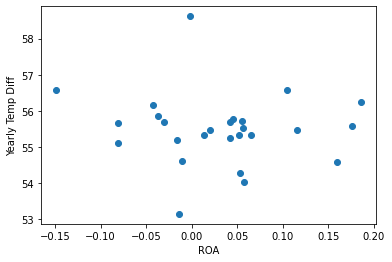

In [17]:
for comp in ROA_data.keys(): 
    temp_data, roa_data = temp_diff_roa_pairs(2, comp)
    corr_ana(roa_data, temp_data, 'ROA', 'Yearly Temp Diff')

## 3 Year

123

Data Insufficient.

123
Correlation analysis between YTEN and montly temp difference:
        Perason coefficient is -0.279 with 0.407 p-value.
        Spearman coefficient is -0.036 with 0.915 p-value.
        Kendall coefficient is 0.055 with 0.879 p-value.
        


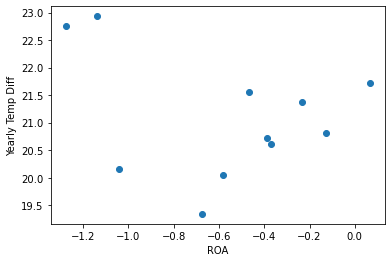

123
Correlation analysis between AVD and montly temp difference:
        Perason coefficient is 0.091 with 0.652 p-value.
        Spearman coefficient is 0.102 with 0.614 p-value.
        Kendall coefficient is 0.092 with 0.515 p-value.
        


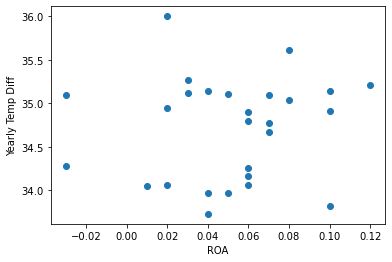

123

Data Insufficient.

123
Correlation analysis between IPI and montly temp difference:
        Perason coefficient is -0.591 with 0.162 p-value.
        Spearman coefficient is -0.321 with 0.482 p-value.
        Kendall coefficient is -0.143 with 0.773 p-value.
        


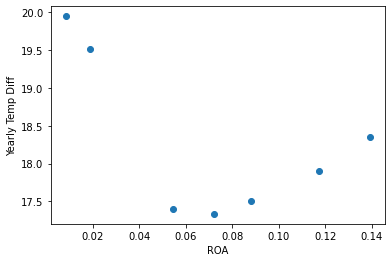

123
Correlation analysis between MGPI and montly temp difference:
        Perason coefficient is 0.008 with 0.968 p-value.
        Spearman coefficient is 0.173 with 0.408 p-value.
        Kendall coefficient is 0.133 with 0.366 p-value.
        


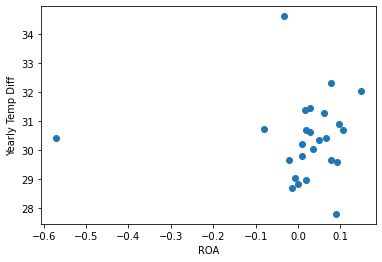

123
Correlation analysis between SMG and montly temp difference:
        Perason coefficient is 0.264 with 0.223 p-value.
        Spearman coefficient is 0.392 with 0.064 p-value.
        Kendall coefficient is 0.225 with 0.140 p-value.
        


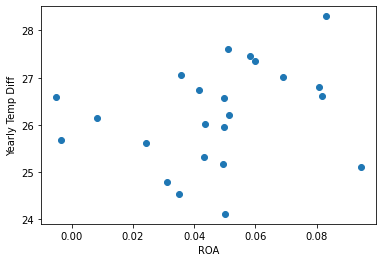

123
Correlation analysis between FMC and montly temp difference:
        Perason coefficient is 0.186 with 0.353 p-value.
        Spearman coefficient is 0.238 with 0.232 p-value.
        Kendall coefficient is 0.134 with 0.341 p-value.
        


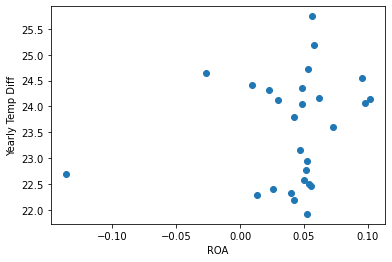

123

Data Insufficient.

123

Data Insufficient.

123

Data Insufficient.

123
Correlation analysis between CF and montly temp difference:
        Perason coefficient is 0.319 with 0.312 p-value.
        Spearman coefficient is 0.203 with 0.527 p-value.
        Kendall coefficient is 0.212 with 0.381 p-value.
        


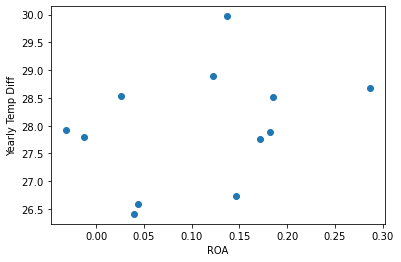

123

Data Insufficient.

123
Correlation analysis between MOS and montly temp difference:
        Perason coefficient is -0.019 with 0.925 p-value.
        Spearman coefficient is -0.013 with 0.951 p-value.
        Kendall coefficient is -0.028 with 0.861 p-value.
        


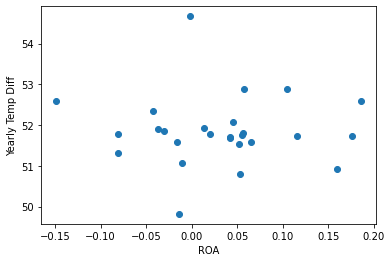

In [18]:
for comp in ROA_data.keys(): 
    temp_data, roa_data = temp_diff_roa_pairs(3, comp)
    corr_ana(roa_data, temp_data, 'ROA', 'Yearly Temp Diff')

## 4 Year

123

Data Insufficient.

123
Correlation analysis between YTEN and montly temp difference:
        Perason coefficient is -0.251 with 0.457 p-value.
        Spearman coefficient is -0.045 with 0.894 p-value.
        Kendall coefficient is 0.055 with 0.879 p-value.
        


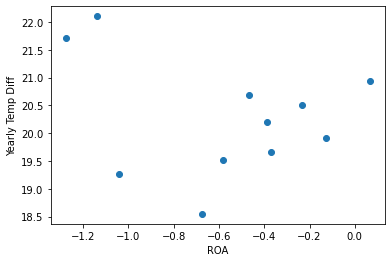

123
Correlation analysis between AVD and montly temp difference:
        Perason coefficient is 0.015 with 0.940 p-value.
        Spearman coefficient is 0.154 with 0.443 p-value.
        Kendall coefficient is 0.121 with 0.389 p-value.
        


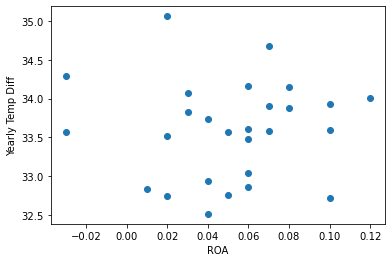

123

Data Insufficient.

123
Correlation analysis between IPI and montly temp difference:
        Perason coefficient is -0.639 with 0.122 p-value.
        Spearman coefficient is -0.321 with 0.482 p-value.
        Kendall coefficient is -0.143 with 0.773 p-value.
        


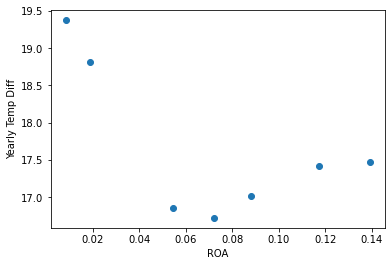

123
Correlation analysis between MGPI and montly temp difference:
        Perason coefficient is 0.034 with 0.870 p-value.
        Spearman coefficient is 0.282 with 0.173 p-value.
        Kendall coefficient is 0.213 with 0.142 p-value.
        


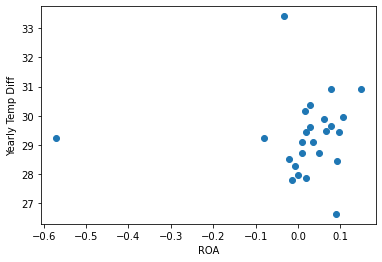

123
Correlation analysis between SMG and montly temp difference:
        Perason coefficient is 0.303 with 0.160 p-value.
        Spearman coefficient is 0.419 with 0.047 p-value.
        Kendall coefficient is 0.257 with 0.091 p-value.
        


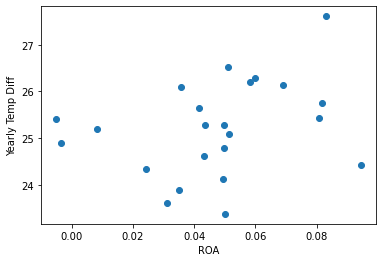

123
Correlation analysis between FMC and montly temp difference:
        Perason coefficient is 0.190 with 0.344 p-value.
        Spearman coefficient is 0.291 with 0.141 p-value.
        Kendall coefficient is 0.191 with 0.170 p-value.
        


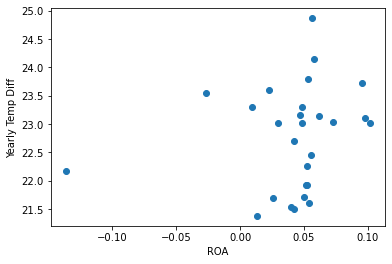

123

Data Insufficient.

123

Data Insufficient.

123

Data Insufficient.

123
Correlation analysis between CF and montly temp difference:
        Perason coefficient is 0.326 with 0.302 p-value.
        Spearman coefficient is 0.259 with 0.417 p-value.
        Kendall coefficient is 0.212 with 0.381 p-value.
        


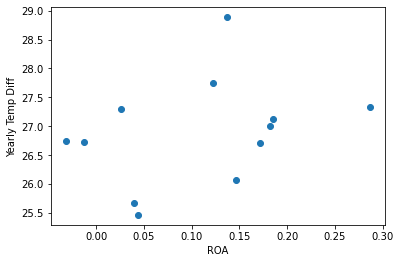

123

Data Insufficient.

123
Correlation analysis between MOS and montly temp difference:
        Perason coefficient is 0.054 with 0.794 p-value.
        Spearman coefficient is 0.083 with 0.687 p-value.
        Kendall coefficient is 0.034 with 0.827 p-value.
        


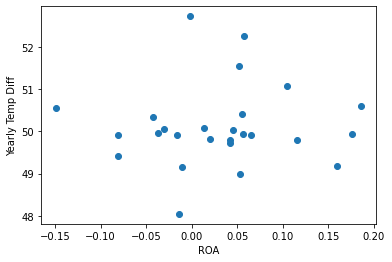

In [19]:
for comp in ROA_data.keys(): 
    temp_data, roa_data = temp_diff_roa_pairs(4, comp)
    corr_ana(roa_data, temp_data, 'ROA', 'Yearly Temp Diff')

## 5 Year

123

Data Insufficient.

123
Correlation analysis between YTEN and montly temp difference:
        Perason coefficient is -0.248 with 0.463 p-value.
        Spearman coefficient is 0.000 with 1.000 p-value.
        Kendall coefficient is 0.091 with 0.761 p-value.
        


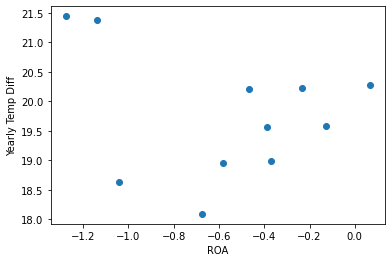

123
Correlation analysis between AVD and montly temp difference:
        Perason coefficient is -0.106 with 0.597 p-value.
        Spearman coefficient is 0.061 with 0.763 p-value.
        Kendall coefficient is 0.062 with 0.659 p-value.
        


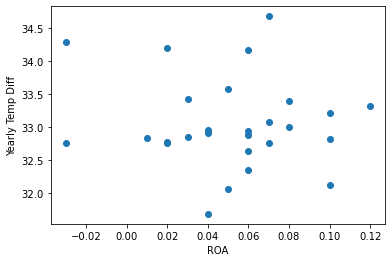

123

Data Insufficient.

123
Correlation analysis between IPI and montly temp difference:
        Perason coefficient is -0.633 with 0.127 p-value.
        Spearman coefficient is -0.321 with 0.482 p-value.
        Kendall coefficient is -0.143 with 0.773 p-value.
        


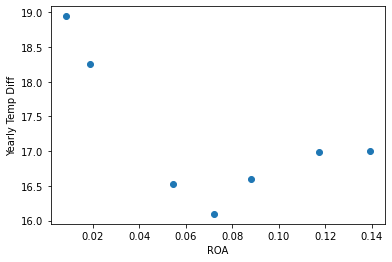

123
Correlation analysis between MGPI and montly temp difference:
        Perason coefficient is 0.173 with 0.409 p-value.
        Spearman coefficient is 0.409 with 0.042 p-value.
        Kendall coefficient is 0.340 with 0.017 p-value.
        


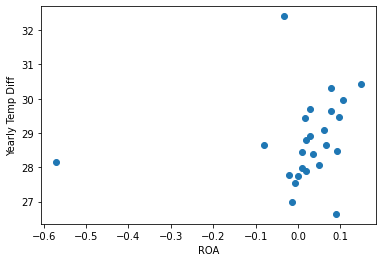

123
Correlation analysis between SMG and montly temp difference:
        Perason coefficient is 0.214 with 0.328 p-value.
        Spearman coefficient is 0.332 with 0.122 p-value.
        Kendall coefficient is 0.186 with 0.227 p-value.
        


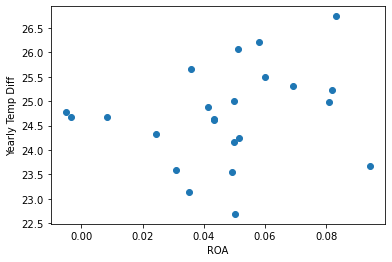

123
Correlation analysis between FMC and montly temp difference:
        Perason coefficient is 0.157 with 0.434 p-value.
        Spearman coefficient is 0.253 with 0.203 p-value.
        Kendall coefficient is 0.151 with 0.281 p-value.
        


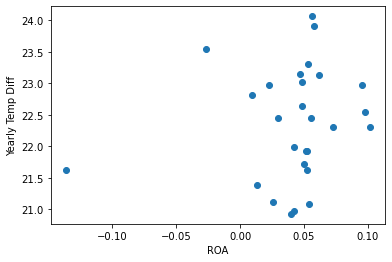

123

Data Insufficient.

123

Data Insufficient.

123

Data Insufficient.

123
Correlation analysis between CF and montly temp difference:
        Perason coefficient is 0.279 with 0.380 p-value.
        Spearman coefficient is 0.196 with 0.542 p-value.
        Kendall coefficient is 0.182 with 0.459 p-value.
        


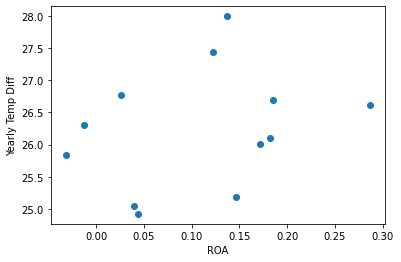

123

Data Insufficient.

123
Correlation analysis between MOS and montly temp difference:
        Perason coefficient is -0.022 with 0.917 p-value.
        Spearman coefficient is -0.065 with 0.754 p-value.
        Kendall coefficient is -0.040 with 0.793 p-value.
        


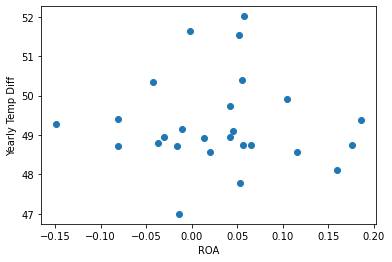

In [20]:
for comp in ROA_data.keys(): 
    temp_data, roa_data = temp_diff_roa_pairs(5, comp)
    corr_ana(roa_data, temp_data, 'ROA', 'Yearly Temp Diff')

## 6 Year

123

Data Insufficient.

123
Correlation analysis between YTEN and montly temp difference:
        Perason coefficient is -0.233 with 0.490 p-value.
        Spearman coefficient is 0.009 with 0.979 p-value.
        Kendall coefficient is 0.127 with 0.648 p-value.
        


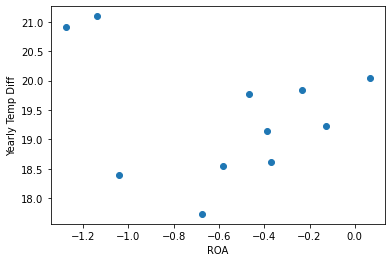

123
Correlation analysis between AVD and montly temp difference:
        Perason coefficient is -0.273 with 0.168 p-value.
        Spearman coefficient is -0.332 with 0.091 p-value.
        Kendall coefficient is -0.204 with 0.147 p-value.
        


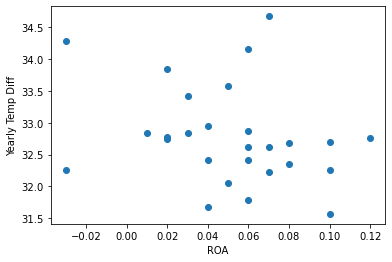

123

Data Insufficient.

123
Correlation analysis between IPI and montly temp difference:
        Perason coefficient is -0.605 with 0.150 p-value.
        Spearman coefficient is -0.321 with 0.482 p-value.
        Kendall coefficient is -0.143 with 0.773 p-value.
        


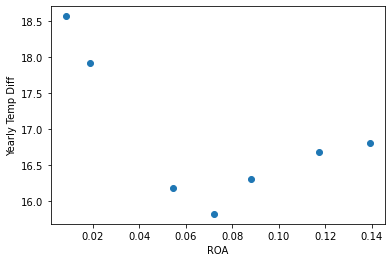

123
Correlation analysis between MGPI and montly temp difference:
        Perason coefficient is 0.195 with 0.350 p-value.
        Spearman coefficient is 0.412 with 0.041 p-value.
        Kendall coefficient is 0.320 with 0.025 p-value.
        


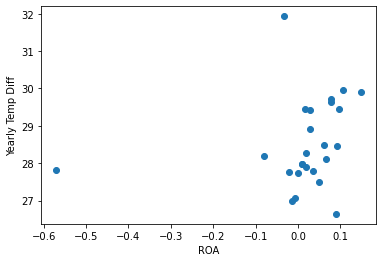

123
Correlation analysis between SMG and montly temp difference:
        Perason coefficient is 0.094 with 0.669 p-value.
        Spearman coefficient is 0.185 with 0.399 p-value.
        Kendall coefficient is 0.091 with 0.565 p-value.
        


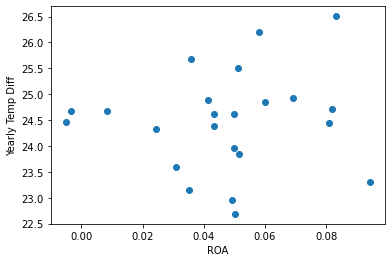

123
Correlation analysis between FMC and montly temp difference:
        Perason coefficient is 0.088 with 0.663 p-value.
        Spearman coefficient is 0.252 with 0.205 p-value.
        Kendall coefficient is 0.168 with 0.229 p-value.
        


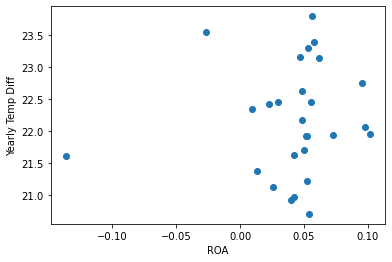

123

Data Insufficient.

123

Data Insufficient.

123

Data Insufficient.

123
Correlation analysis between CF and montly temp difference:
        Perason coefficient is 0.299 with 0.346 p-value.
        Spearman coefficient is 0.203 with 0.527 p-value.
        Kendall coefficient is 0.212 with 0.381 p-value.
        


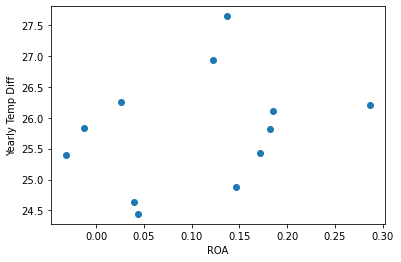

123

Data Insufficient.

123
Correlation analysis between MOS and montly temp difference:
        Perason coefficient is -0.145 with 0.481 p-value.
        Spearman coefficient is -0.249 with 0.220 p-value.
        Kendall coefficient is -0.145 with 0.314 p-value.
        


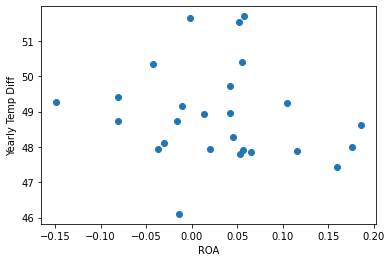

In [21]:
for comp in ROA_data.keys(): 
    temp_data, roa_data = temp_diff_roa_pairs(6, comp)
    corr_ana(roa_data, temp_data, 'ROA', 'Yearly Temp Diff')

## 7 Year

123

Data Insufficient.

123
Correlation analysis between YTEN and montly temp difference:
        Perason coefficient is -0.217 with 0.521 p-value.
        Spearman coefficient is -0.027 with 0.937 p-value.
        Kendall coefficient is 0.055 with 0.879 p-value.
        


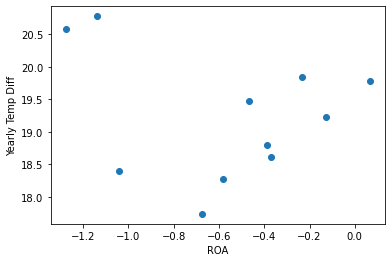

123
Correlation analysis between AVD and montly temp difference:
        Perason coefficient is -0.261 with 0.189 p-value.
        Spearman coefficient is -0.307 with 0.120 p-value.
        Kendall coefficient is -0.198 with 0.159 p-value.
        


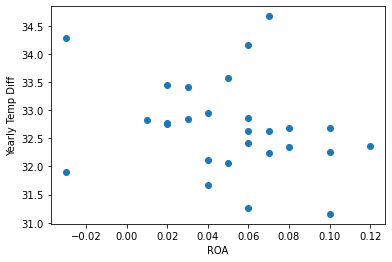

123

Data Insufficient.

123
Correlation analysis between IPI and montly temp difference:
        Perason coefficient is -0.571 with 0.180 p-value.
        Spearman coefficient is -0.393 with 0.383 p-value.
        Kendall coefficient is -0.238 with 0.562 p-value.
        


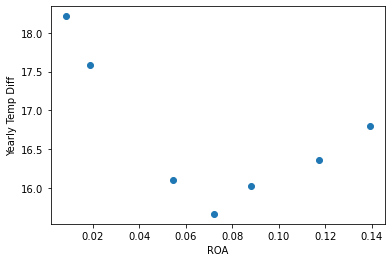

123
Correlation analysis between MGPI and montly temp difference:
        Perason coefficient is 0.257 with 0.214 p-value.
        Spearman coefficient is 0.415 with 0.039 p-value.
        Kendall coefficient is 0.307 with 0.033 p-value.
        


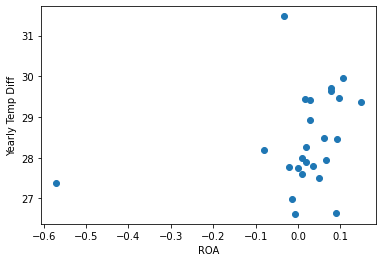

123
Correlation analysis between SMG and montly temp difference:
        Perason coefficient is -0.032 with 0.885 p-value.
        Spearman coefficient is 0.009 with 0.968 p-value.
        Kendall coefficient is -0.020 with 0.917 p-value.
        


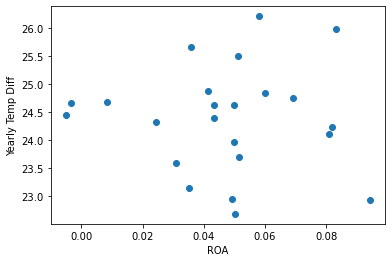

123
Correlation analysis between FMC and montly temp difference:
        Perason coefficient is 0.028 with 0.891 p-value.
        Spearman coefficient is 0.145 with 0.470 p-value.
        Kendall coefficient is 0.088 with 0.535 p-value.
        


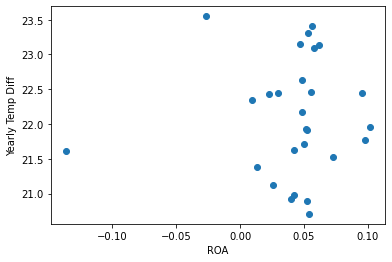

123

Data Insufficient.

123

Data Insufficient.

123

Data Insufficient.

123
Correlation analysis between CF and montly temp difference:
        Perason coefficient is 0.239 with 0.454 p-value.
        Spearman coefficient is 0.154 with 0.633 p-value.
        Kendall coefficient is 0.212 with 0.381 p-value.
        


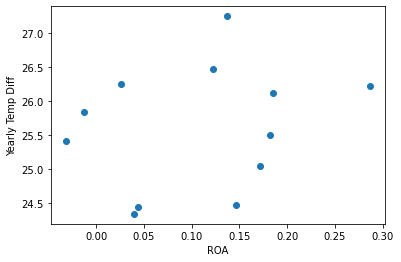

123

Data Insufficient.

123
Correlation analysis between MOS and montly temp difference:
        Perason coefficient is -0.235 with 0.248 p-value.
        Spearman coefficient is -0.318 with 0.114 p-value.
        Kendall coefficient is -0.206 with 0.147 p-value.
        


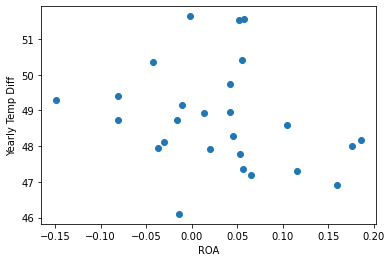

In [22]:
for comp in ROA_data.keys(): 
    temp_data, roa_data = temp_diff_roa_pairs(7, comp)
    corr_ana(roa_data, temp_data, 'ROA', 'Yearly Temp Diff')

## 8 Year

123

Data Insufficient.

123
Correlation analysis between YTEN and montly temp difference:
        Perason coefficient is -0.217 with 0.521 p-value.
        Spearman coefficient is -0.027 with 0.937 p-value.
        Kendall coefficient is 0.055 with 0.879 p-value.
        


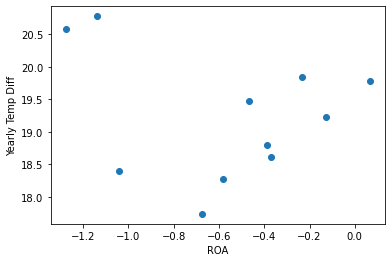

123
Correlation analysis between AVD and montly temp difference:
        Perason coefficient is -0.261 with 0.189 p-value.
        Spearman coefficient is -0.307 with 0.120 p-value.
        Kendall coefficient is -0.198 with 0.159 p-value.
        


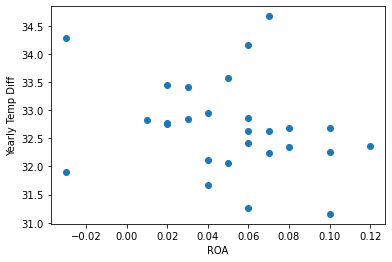

123

Data Insufficient.

123
Correlation analysis between IPI and montly temp difference:
        Perason coefficient is -0.571 with 0.180 p-value.
        Spearman coefficient is -0.393 with 0.383 p-value.
        Kendall coefficient is -0.238 with 0.562 p-value.
        


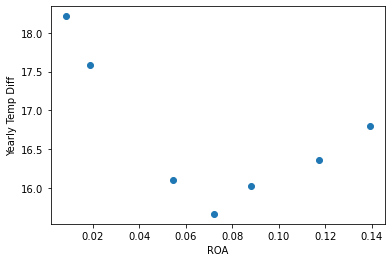

123
Correlation analysis between MGPI and montly temp difference:
        Perason coefficient is 0.257 with 0.214 p-value.
        Spearman coefficient is 0.415 with 0.039 p-value.
        Kendall coefficient is 0.307 with 0.033 p-value.
        


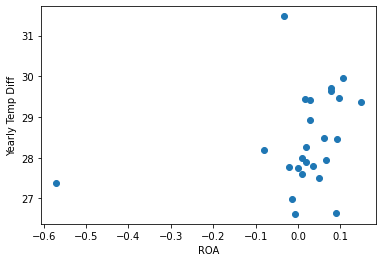

123
Correlation analysis between SMG and montly temp difference:
        Perason coefficient is -0.032 with 0.885 p-value.
        Spearman coefficient is 0.009 with 0.968 p-value.
        Kendall coefficient is -0.020 with 0.917 p-value.
        


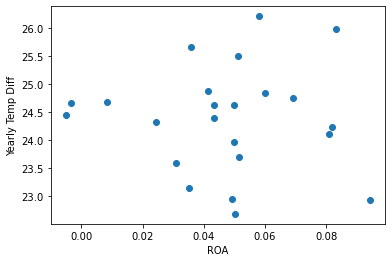

123
Correlation analysis between FMC and montly temp difference:
        Perason coefficient is 0.028 with 0.891 p-value.
        Spearman coefficient is 0.145 with 0.470 p-value.
        Kendall coefficient is 0.088 with 0.535 p-value.
        


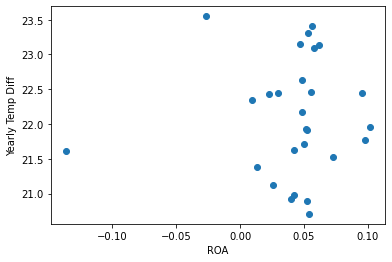

123

Data Insufficient.

123

Data Insufficient.

123

Data Insufficient.

123
Correlation analysis between CF and montly temp difference:
        Perason coefficient is 0.239 with 0.454 p-value.
        Spearman coefficient is 0.154 with 0.633 p-value.
        Kendall coefficient is 0.212 with 0.381 p-value.
        


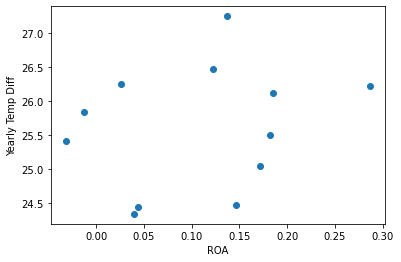

123

Data Insufficient.

123
Correlation analysis between MOS and montly temp difference:
        Perason coefficient is -0.235 with 0.248 p-value.
        Spearman coefficient is -0.318 with 0.114 p-value.
        Kendall coefficient is -0.206 with 0.147 p-value.
        


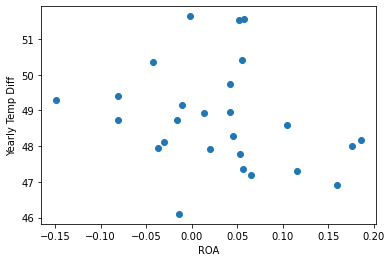

In [23]:
for comp in ROA_data.keys(): 
    temp_data, roa_data = temp_diff_roa_pairs(8, comp)
    corr_ana(roa_data, temp_data, 'ROA', 'Yearly Temp Diff')

## 9 Year

123

Data Insufficient.

123
Correlation analysis between YTEN and montly temp difference:
        Perason coefficient is -0.217 with 0.521 p-value.
        Spearman coefficient is -0.027 with 0.937 p-value.
        Kendall coefficient is 0.055 with 0.879 p-value.
        


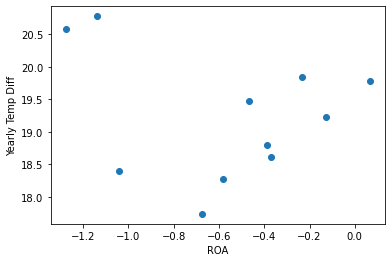

123
Correlation analysis between AVD and montly temp difference:
        Perason coefficient is -0.261 with 0.189 p-value.
        Spearman coefficient is -0.307 with 0.120 p-value.
        Kendall coefficient is -0.198 with 0.159 p-value.
        


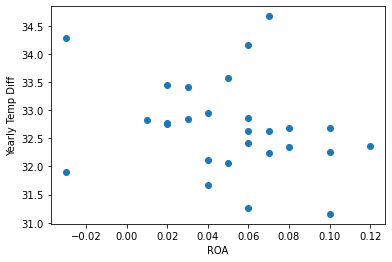

123

Data Insufficient.

123
Correlation analysis between IPI and montly temp difference:
        Perason coefficient is -0.571 with 0.180 p-value.
        Spearman coefficient is -0.393 with 0.383 p-value.
        Kendall coefficient is -0.238 with 0.562 p-value.
        


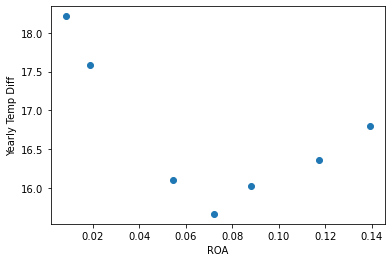

123
Correlation analysis between MGPI and montly temp difference:
        Perason coefficient is 0.257 with 0.214 p-value.
        Spearman coefficient is 0.415 with 0.039 p-value.
        Kendall coefficient is 0.307 with 0.033 p-value.
        


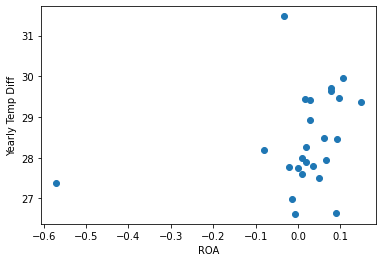

123
Correlation analysis between SMG and montly temp difference:
        Perason coefficient is -0.032 with 0.885 p-value.
        Spearman coefficient is 0.009 with 0.968 p-value.
        Kendall coefficient is -0.020 with 0.917 p-value.
        


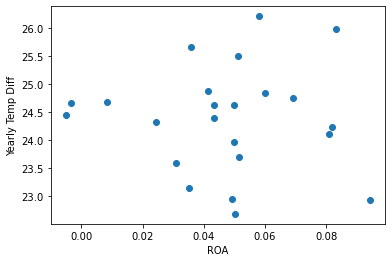

123
Correlation analysis between FMC and montly temp difference:
        Perason coefficient is 0.028 with 0.891 p-value.
        Spearman coefficient is 0.145 with 0.470 p-value.
        Kendall coefficient is 0.088 with 0.535 p-value.
        


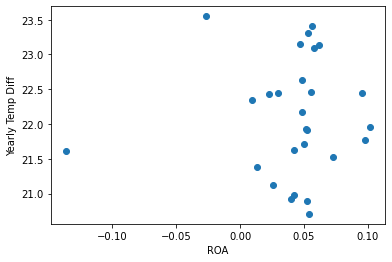

123

Data Insufficient.

123

Data Insufficient.

123

Data Insufficient.

123
Correlation analysis between CF and montly temp difference:
        Perason coefficient is 0.239 with 0.454 p-value.
        Spearman coefficient is 0.154 with 0.633 p-value.
        Kendall coefficient is 0.212 with 0.381 p-value.
        


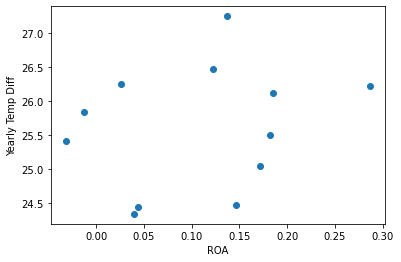

123

Data Insufficient.

123
Correlation analysis between MOS and montly temp difference:
        Perason coefficient is -0.235 with 0.248 p-value.
        Spearman coefficient is -0.318 with 0.114 p-value.
        Kendall coefficient is -0.206 with 0.147 p-value.
        


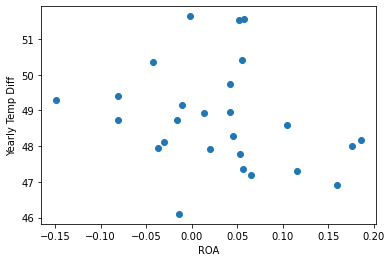

In [24]:
for comp in ROA_data.keys(): 
    temp_data, roa_data = temp_diff_roa_pairs(9, comp)
    corr_ana(roa_data, temp_data, 'ROA', 'Yearly Temp Diff')

## 10 Year

123

Data Insufficient.

123
Correlation analysis between YTEN and montly temp difference:
        Perason coefficient is -0.217 with 0.521 p-value.
        Spearman coefficient is -0.027 with 0.937 p-value.
        Kendall coefficient is 0.055 with 0.879 p-value.
        


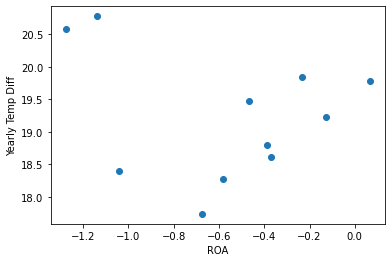

123
Correlation analysis between AVD and montly temp difference:
        Perason coefficient is -0.261 with 0.189 p-value.
        Spearman coefficient is -0.307 with 0.120 p-value.
        Kendall coefficient is -0.198 with 0.159 p-value.
        


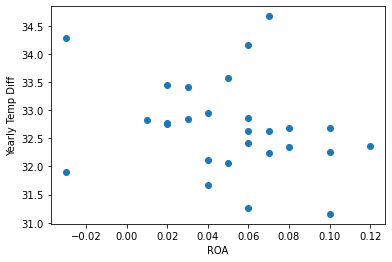

123

Data Insufficient.

123
Correlation analysis between IPI and montly temp difference:
        Perason coefficient is -0.571 with 0.180 p-value.
        Spearman coefficient is -0.393 with 0.383 p-value.
        Kendall coefficient is -0.238 with 0.562 p-value.
        


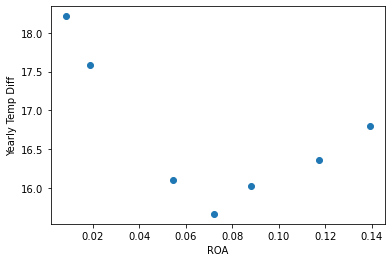

123
Correlation analysis between MGPI and montly temp difference:
        Perason coefficient is 0.257 with 0.214 p-value.
        Spearman coefficient is 0.415 with 0.039 p-value.
        Kendall coefficient is 0.307 with 0.033 p-value.
        


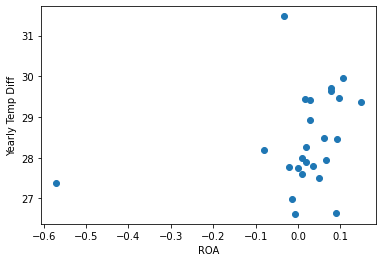

123
Correlation analysis between SMG and montly temp difference:
        Perason coefficient is -0.032 with 0.885 p-value.
        Spearman coefficient is 0.009 with 0.968 p-value.
        Kendall coefficient is -0.020 with 0.917 p-value.
        


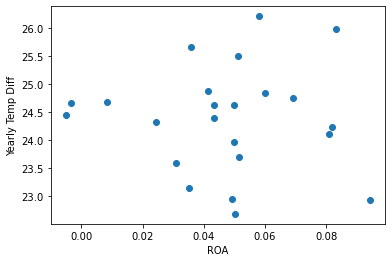

123
Correlation analysis between FMC and montly temp difference:
        Perason coefficient is 0.028 with 0.891 p-value.
        Spearman coefficient is 0.145 with 0.470 p-value.
        Kendall coefficient is 0.088 with 0.535 p-value.
        


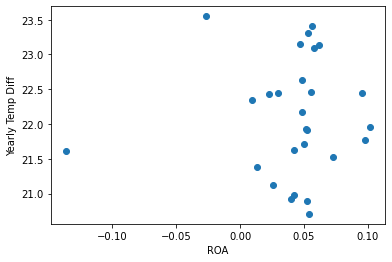

123

Data Insufficient.

123

Data Insufficient.

123

Data Insufficient.

123
Correlation analysis between CF and montly temp difference:
        Perason coefficient is 0.239 with 0.454 p-value.
        Spearman coefficient is 0.154 with 0.633 p-value.
        Kendall coefficient is 0.212 with 0.381 p-value.
        


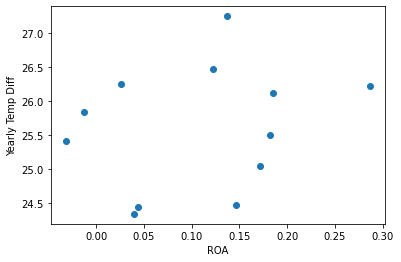

123

Data Insufficient.

123
Correlation analysis between MOS and montly temp difference:
        Perason coefficient is -0.235 with 0.248 p-value.
        Spearman coefficient is -0.318 with 0.114 p-value.
        Kendall coefficient is -0.206 with 0.147 p-value.
        


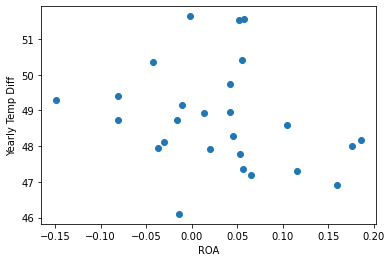

In [25]:
for comp in ROA_data.keys(): 
    temp_data, roa_data = temp_diff_roa_pairs(10, comp)
    corr_ana(roa_data, temp_data, 'ROA', 'Yearly Temp Diff')

# Bushfires

123
Correlation analysis between RKDA and montly temp difference:
        Perason coefficient is 0.448 with 0.227 p-value.
        Spearman coefficient is 0.467 with 0.205 p-value.
        Kendall coefficient is 0.278 with 0.358 p-value.
        


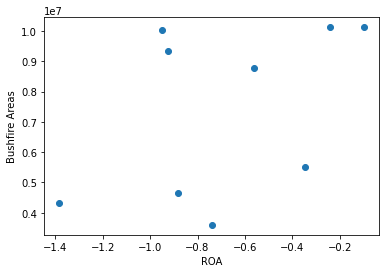

123
Correlation analysis between YTEN and montly temp difference:
        Perason coefficient is 0.383 with 0.116 p-value.
        Spearman coefficient is 0.313 with 0.206 p-value.
        Kendall coefficient is 0.216 with 0.229 p-value.
        


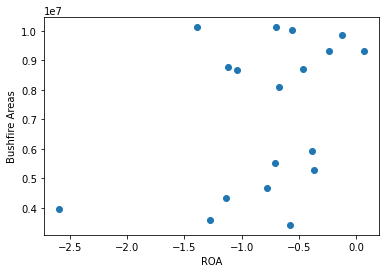

123
Correlation analysis between AVD and montly temp difference:
        Perason coefficient is 0.150 with 0.389 p-value.
        Spearman coefficient is 0.112 with 0.520 p-value.
        Kendall coefficient is 0.072 with 0.558 p-value.
        


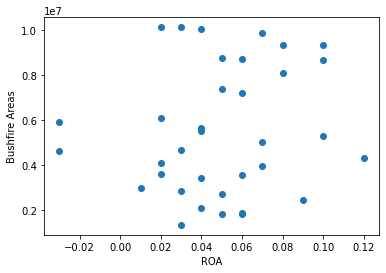

123

Data Insufficient.

123
Correlation analysis between IPI and montly temp difference:
        Perason coefficient is -0.175 with 0.532 p-value.
        Spearman coefficient is -0.114 with 0.685 p-value.
        Kendall coefficient is -0.029 with 0.923 p-value.
        


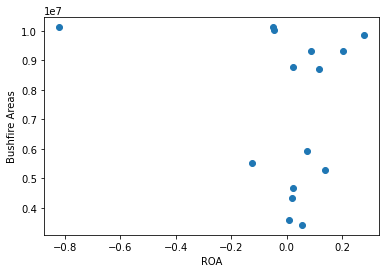

123
Correlation analysis between MGPI and montly temp difference:
        Perason coefficient is 0.046 with 0.801 p-value.
        Spearman coefficient is 0.106 with 0.559 p-value.
        Kendall coefficient is 0.076 with 0.549 p-value.
        


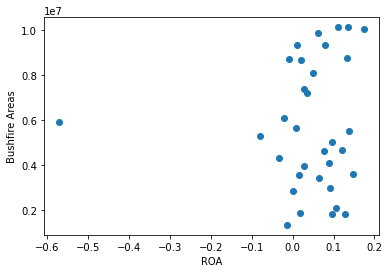

123
Correlation analysis between SMG and montly temp difference:
        Perason coefficient is 0.210 with 0.256 p-value.
        Spearman coefficient is 0.276 with 0.133 p-value.
        Kendall coefficient is 0.209 with 0.103 p-value.
        


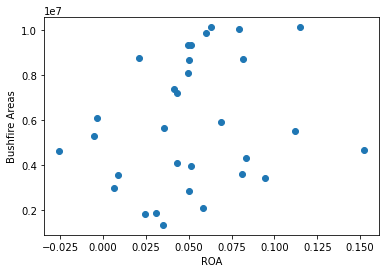

123
Correlation analysis between FMC and montly temp difference:
        Perason coefficient is 0.305 with 0.075 p-value.
        Spearman coefficient is 0.266 with 0.123 p-value.
        Kendall coefficient is 0.170 with 0.151 p-value.
        


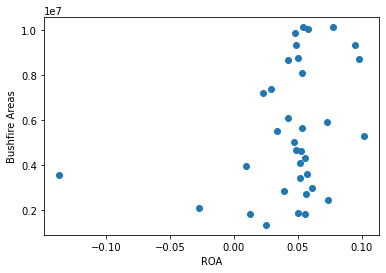

123
Correlation analysis between MBII and montly temp difference:
        Perason coefficient is -0.222 with 0.538 p-value.
        Spearman coefficient is -0.018 with 0.960 p-value.
        Kendall coefficient is -0.022 with 1.000 p-value.
        


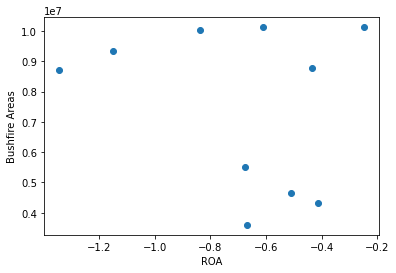

123

Data Insufficient.

123
Correlation analysis between UAN and montly temp difference:
        Perason coefficient is -0.321 with 0.284 p-value.
        Spearman coefficient is -0.330 with 0.271 p-value.
        Kendall coefficient is -0.231 with 0.306 p-value.
        


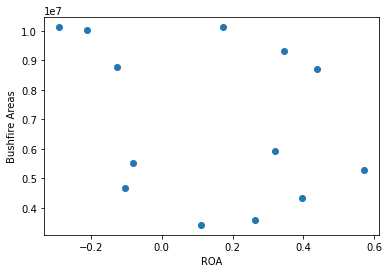

123
Correlation analysis between CF and montly temp difference:
        Perason coefficient is -0.080 with 0.746 p-value.
        Spearman coefficient is -0.004 with 0.989 p-value.
        Kendall coefficient is 0.041 with 0.836 p-value.
        


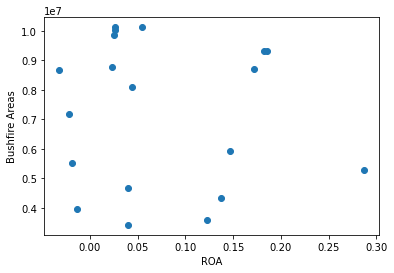

123

Data Insufficient.

123
Correlation analysis between MOS and montly temp difference:
        Perason coefficient is 0.118 with 0.512 p-value.
        Spearman coefficient is 0.099 with 0.583 p-value.
        Kendall coefficient is 0.082 with 0.505 p-value.
        


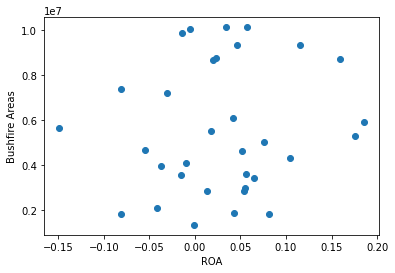

In [26]:
for comp in ROA_data.keys(): 
    roa_data = []
    temp_data = []
    for i in ROA_data[comp].iloc[:,range(1, ROA_data[comp].shape[1])]:
        year = i.split('/')[-1]
        
        try: 
            t = bushfire_data.loc[bushfire_data['Year'] == int(year)]['Acres']
            t = int(t.values[0].replace(',', ''))
            if t:
                roa = ROA_data[comp][i][0]
                roa = float(roa)
                if roa and not np.isnan(roa):
                    roa_data.append(roa)
                    temp_data.append(t)
        except:
            pass
    corr_ana(roa_data, temp_data, 'ROA', 'Bushfire Areas')

# Appendix

## Person

$$
r=\frac{\sum\left(x-m_{x}\right)\left(y-m_{y}\right)}{\sqrt{\sum\left(x-m_{x}\right)^{2} \sum\left(y-m_{y}\right)^{2}}}
$$

REF: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

## Spearman

$$
\rho=1-\frac{6 \sum d_{i}^{2}}{n\left(n^{2}-1\right)}
$$

$\rho$ 	=	Spearman's rank correlation coefficient  
$d_i$ = difference between the two ranks of each observation  
$n$ = number of observations

REF1: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html  
REF2: https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient

## Kendall

$$
\tau=\frac{(\text { number of concordant pairs })-(\text { number of discordant pairs })}{\left(\begin{array}{c}
n \\
2
\end{array}\right)}
$$

REF: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html?highlight=kendall#scipy.stats.kendalltau